# Exercise 3

Use logistic regression to predict the probability of a passenger surviving.

https://www.kaggle.com/competitions/titanic/overview

In [1]:
print("==============")
print(" James Adrian Castro ")
print("==============")
print("CCMACLRL COM231ML")


 James Adrian Castro 
CCMACLRL COM231ML


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import warnings
warnings.filterwarnings('ignore')

## Datasets

In [ ]:
print("Loading datasets...")
dataset_url = 'https://github.com/robitussin/CCMACLRL_EXERCISES_OLD/blob/f5fdfba1aabbbafcf2fe49ca6e1c8f92f69d1458/datasets/titanic/train.csv?raw=true'
test_url = 'https://github.com/robitussin/CCMACLRL_EXERCISES_OLD/blob/f5fdfba1aabbbafcf2fe49ca6e1c8f92f69d1458/datasets/titanic/test.csv?raw=true'

df = pd.read_csv(dataset_url)
dt = pd.read_csv(test_url)

print("Training data shape:", df.shape)
print("Test data shape:", dt.shape)

Loading datasets...
Training data shape: (891, 12)
Test data shape: (418, 11)


##Training Data Info

In [ ]:
print(df.info())
print("\nFirst few rows:")
print(df.head())

print("\nSurvival rate:")
print(df['Survived'].value_counts(normalize=True))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None

First few rows:
   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

     

In [ ]:
dt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.1+ KB


##Data Processing

In [ ]:
def preprocess_data(data, is_train=True):
    """Preprocess the Titanic data"""

    # Create a copy to avoid modifying original data
    data = data.copy()

    # Fill missing ages with median
    data['Age'].fillna(data['Age'].median(), inplace=True)

    # Fill missing embarked with mode
    if 'Embarked' in data.columns:
        data['Embarked'].fillna(data['Embarked'].mode()[0], inplace=True)

    # Fill missing fare with median (for test set)
    if 'Fare' in data.columns:
        data['Fare'].fillna(data['Fare'].median(), inplace=True)

    # Create family size feature
    data['FamilySize'] = data['SibSp'] + data['Parch'] + 1

    # Create is_alone feature
    data['IsAlone'] = (data['FamilySize'] == 1).astype(int)

    # Extract title from name
    data['Title'] = data['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)

    # Group rare titles
    title_mapping = {
        'Mr': 'Mr', 'Miss': 'Miss', 'Mrs': 'Mrs', 'Master': 'Master',
        'Dr': 'Rare', 'Rev': 'Rare', 'Col': 'Rare', 'Major': 'Rare',
        'Mlle': 'Miss', 'Countess': 'Rare', 'Ms': 'Miss', 'Lady': 'Rare',
        'Jonkheer': 'Rare', 'Don': 'Rare', 'Dona': 'Rare', 'Mme': 'Mrs',
        'Capt': 'Rare', 'Sir': 'Rare'
    }
    data['Title'] = data['Title'].map(title_mapping)
    data['Title'].fillna('Rare', inplace=True)

    # Create age groups
    data['AgeGroup'] = pd.cut(data['Age'], bins=[0, 12, 18, 35, 60, 100],
                              labels=['Child', 'Teenager', 'Adult', 'MiddleAge', 'Senior'])

    # Create fare groups
    data['FareGroup'] = pd.qcut(data['Fare'], q=4, labels=['Low', 'Medium', 'High', 'VeryHigh'])

    # Select features for modeling
    categorical_features = ['Sex', 'Embarked', 'Title', 'AgeGroup', 'FareGroup']
    numerical_features = ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'FamilySize', 'IsAlone']

    # Create feature matrix
    feature_data = data[numerical_features].copy()

    # Encode categorical variables and store encoders
    label_encoders = {}
    for feature in categorical_features:
        if feature in data.columns:
            le = LabelEncoder()
            feature_data[feature] = le.fit_transform(data[feature].astype(str))
            label_encoders[feature] = le

    return feature_data, label_encoders

##Processing Data

In [ ]:
X, label_encoders = preprocess_data(df, is_train=True)
y = df['Survived']

print("Features used:", X.columns.tolist())
print("Feature matrix shape:", X.shape)

# Split training data for validation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

Features used: ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'FamilySize', 'IsAlone', 'Sex', 'Embarked', 'Title', 'AgeGroup', 'FareGroup']
Feature matrix shape: (891, 12)


##SPLIT Data

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Training set: {X_train.shape}")
print(f"Validation set: {X_val.shape}")

# Train logistic regression model
print("\n=== TRAINING LOGISTIC REGRESSION MODEL ===")
model = LogisticRegression(random_state=42, max_iter=1000)
model.fit(X_train, y_train)

Training set: (712, 12)
Validation set: (179, 12)

=== TRAINING LOGISTIC REGRESSION MODEL ===


LogisticRegression(max_iter=1000, random_state=42)

##Predictions

In [ ]:
y_val_pred = model.predict(X_val)
y_val_pred_proba = model.predict_proba(X_val)[:, 1]

##MODEL EVALUATION

In [ ]:
accuracy = accuracy_score(y_val, y_val_pred)
print(f"Validation Accuracy: {accuracy:.4f}")

print("\nClassification Report:")
print(classification_report(y_val, y_val_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_val, y_val_pred))


Validation Accuracy: 0.8101

Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.89      0.85       110
           1       0.80      0.68      0.73        69

    accuracy                           0.81       179
   macro avg       0.81      0.79      0.79       179
weighted avg       0.81      0.81      0.81       179


Confusion Matrix:
[[98 12]
 [22 47]]


##FEATURES


In [ ]:
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'coefficient': model.coef_[0],
    'abs_coefficient': np.abs(model.coef_[0])
}).sort_values('abs_coefficient', ascending=False)

print("\n=== FEATURE IMPORTANCE ===")
print(feature_importance)


=== FEATURE IMPORTANCE ===
       feature  coefficient  abs_coefficient
7          Sex    -2.522785         2.522785
0       Pclass    -1.015980         1.015980
6      IsAlone    -0.628592         0.628592
2        SibSp    -0.215585         0.215585
5   FamilySize    -0.205000         0.205000
8     Embarked    -0.194609         0.194609
9        Title    -0.181759         0.181759
1          Age    -0.030305         0.030305
10    AgeGroup    -0.025521         0.025521
11   FareGroup    -0.018917         0.018917
3        Parch     0.006063         0.006063
4         Fare     0.001826         0.001826


##PREPROCESSING TEST DATA

In [ ]:
X_test, _ = preprocess_data(dt, is_train=False)
for feature in label_encoders:
    if feature in X_test.columns:
        le = label_encoders[feature]
        # Handle unseen categories
        X_test[feature] = X_test[feature].astype(str)
        unseen_mask = ~X_test[feature].isin(le.classes_)
        X_test.loc[unseen_mask, feature] = le.classes_[0]  # Use first class for unseen values
        X_test[feature] = le.transform(X_test[feature])

print("Test features shape:", X_test.shape)


Test features shape: (418, 12)


##MAKING PREDICTIONS

In [ ]:
y_test_pred = model.predict(X_test)
y_test_pred_proba = model.predict_proba(X_test)[:, 1]

print(f"Predicted survival rate on test set: {y_test_pred.mean():.3f}")


Predicted survival rate on test set: 0.981


##CONFUSION MATRIX

In [ ]:
from sklearn.model_selection import train_test_split

# Select features (make sure these match your preprocessing)
features = ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'FamilySize', 'IsAlone', 'Sex', 'Embarked', 'Title', 'AgeGroup', 'FareGroup']

X = X # Use the preprocessed feature matrix X from cell jhbHu_m_SisE
y = df["Survived"] # Use the target variable y from cell jhbHu_m_SisE
X_test_processed = X_test # Use the preprocessed test feature matrix X_test from cell wNNGlX91TgV_

# Split into train/validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(max_iter=500)
model.fit(X_train, y_train)

y_val_pred = model.predict(X_val)

              precision    recall  f1-score   support

           0       0.82      0.85      0.83       105
           1       0.77      0.73      0.75        74

    accuracy                           0.80       179
   macro avg       0.79      0.79      0.79       179
weighted avg       0.80      0.80      0.80       179



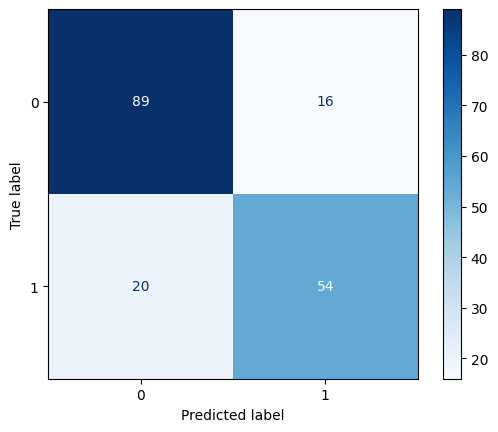

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

cm = confusion_matrix(y_val, y_val_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot(cmap="Blues")

print(classification_report(y_val, y_val_pred))

##SUBMISSION FILE

In [ ]:
sample_submission_url = 'https://github.com/robitussin/CCMACLRL_EXERCISES_OLD/blob/f5fdfba1aabbbafcf2fe49ca6e1c8f92f69d1458/datasets/titanic/gender_submission.csv?raw=true'
sf = pd.read_csv(sample_submission_url)

In [ ]:
submission_df = pd.DataFrame({
    'PassengerId': dt['PassengerId'],
    'Survived': y_test_pred
})


In [ ]:
# Create a submission DataFrame using PassengerId from dt and the predictions
submission_df = pd.DataFrame({
    'PassengerId': dt['PassengerId'],
    'Survived': y_test_pred # Use the predictions made on the preprocessed test data
})

submission_df.to_csv('titanic_submission.csv', index=False)
print("Submission file created: titanic_submission.csv")

Submission file created: titanic_submission.csv


In [ ]:
sf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   PassengerId  418 non-null    int64
 1   Survived     418 non-null    int64
dtypes: int64(2)
memory usage: 6.7 KB


##Show first ten predictions results

In [ ]:
print("\nFirst 10 predictions:")
result_preview = pd.DataFrame({
    'PassengerId': dt['PassengerId'].head(10),
    'Predicted_Survival': y_test_pred[:10],
    'Survival_Probability': y_test_pred_proba[:10]
})
print(result_preview)


First 10 predictions:
   PassengerId  Predicted_Survival  Survival_Probability
0          892                   1              0.692701
1          893                   1              0.654858
2          894                   1              0.730818
3          895                   1              0.739155
4          896                   1              0.770086
5          897                   1              0.807923
6          898                   1              0.720870
7          899                   1              0.894171
8          900                   1              0.787799
9          901                   1              0.738679


##SUMMARY

In [ ]:
print(f"Model: Logistic Regression")
print(f"Validation Accuracy: {accuracy:.4f}")
print(f"Total passengers in test set: {len(dt)}")
print(f"Predicted survivors: {y_test_pred.sum()}")
print(f"Predicted deaths: {len(y_test_pred) - y_test_pred.sum()}")
print(f"Survival rate: {y_test_pred.mean():.3f}")

Model: Logistic Regression
Validation Accuracy: 0.8101
Total passengers in test set: 418
Predicted survivors: 410
Predicted deaths: 8
Survival rate: 0.981


##Download CSV File

In [ ]:
from google.colab import files
files.download("titanic_submission.csv")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>